# 03. London amenities

***17 Aug 2020***

Compare the results of `pois_from_place()` and `gdf_from_place()` against https://overpass-turbo.eu when looking for amenities in London.

- Looking at the time taken for the two functions when working from the cache
- Check the number of results that they each produce
- Search for results that are not actually tagged with the requested tags

#### Note:

`geometries` works strictly with multipolygon relations (see further information in the notebook).

For a query such as:

`ox.gdf_from_place('London, United Kingdom', tags={'amenity': True})`

the comparable query on the overpass-turbo.eu wizard would be:

`amenity=* and (type:node or type:way or (type:relation and type=multipolygon)) in London`

In [1]:
%load_ext autoreload
%autoreload 2

import osmnx as ox # using fork `New geometries module - Work In Progress`
ox.utils.config(use_cache=True, log_console=True)

import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)

### Compare time `pois` and `geometries`

- Both run once from the cache

In [2]:
%%time
pois_amenities = ox.pois_from_place('London, United Kingdom', tags={'amenity': True})

CPU times: user 7min 10s, sys: 14.2 s, total: 7min 24s
Wall time: 7min 24s


In [3]:
%%time
geometries_amenities = ox.gdf_from_place('London, United Kingdom', tags={'amenity': True})

CPU times: user 38.1 s, sys: 3.32 s, total: 41.4 s
Wall time: 41.4 s


### Check for results *not* tagged as amenity

- `pois` only uses the tags in the query
- if a polygon is tagged as an amenity and it's component nodes/ways also have their own tags (any not just amenity) they will be returned in the geodataframe
- `geometries` creates the same query but then applies a strict filter at the end
- it filters by both the keys and the values supplied

In [4]:
# create dataframes of results from each *that are not* tagged with `amenity`
pois_amenities_not_amenities = pois_amenities['amenity'].isna()
geometries_amenities_not_amenities = geometries_amenities['amenity'].isna()

print("pois_amenities.shape", pois_amenities.shape)
print("pois_amenities geometry types:", pois_amenities['geometry'].geom_type.unique())
print("pois_amenities that are not amenities:", pois_amenities_not_amenities.sum())

print("\ngeometries_amenities.shape", geometries_amenities.shape)
print("geometries_amenities geometry types:", geometries_amenities['geometry'].geom_type.unique())
print("geometries_amenities that are not amenities:", geometries_amenities_not_amenities.sum())

pois_amenities.shape (87562, 1296)
pois_amenities geometry types: ['Point' 'Polygon' 'MultiPolygon']
pois_amenities that are not amenities: 4769

geometries_amenities.shape (82877, 1174)
geometries_amenities geometry types: ['Point' 'Polygon' 'LineString' 'MultiPolygon']
geometries_amenities that are not amenities: 0


#### Notes:

- `gdf_from_place()` produces 4685 fewer results, but 4769 of the results from `pois_from_place()` are not tagged as amenities.
- `gdf_from_place()` produces more results that are tagged as `amenity`

### Plot the results

- `pois` results in red are *not* tagged as amenities
- all `pois` results are shown in yellow
- `geometries` results are plotted on top in blue

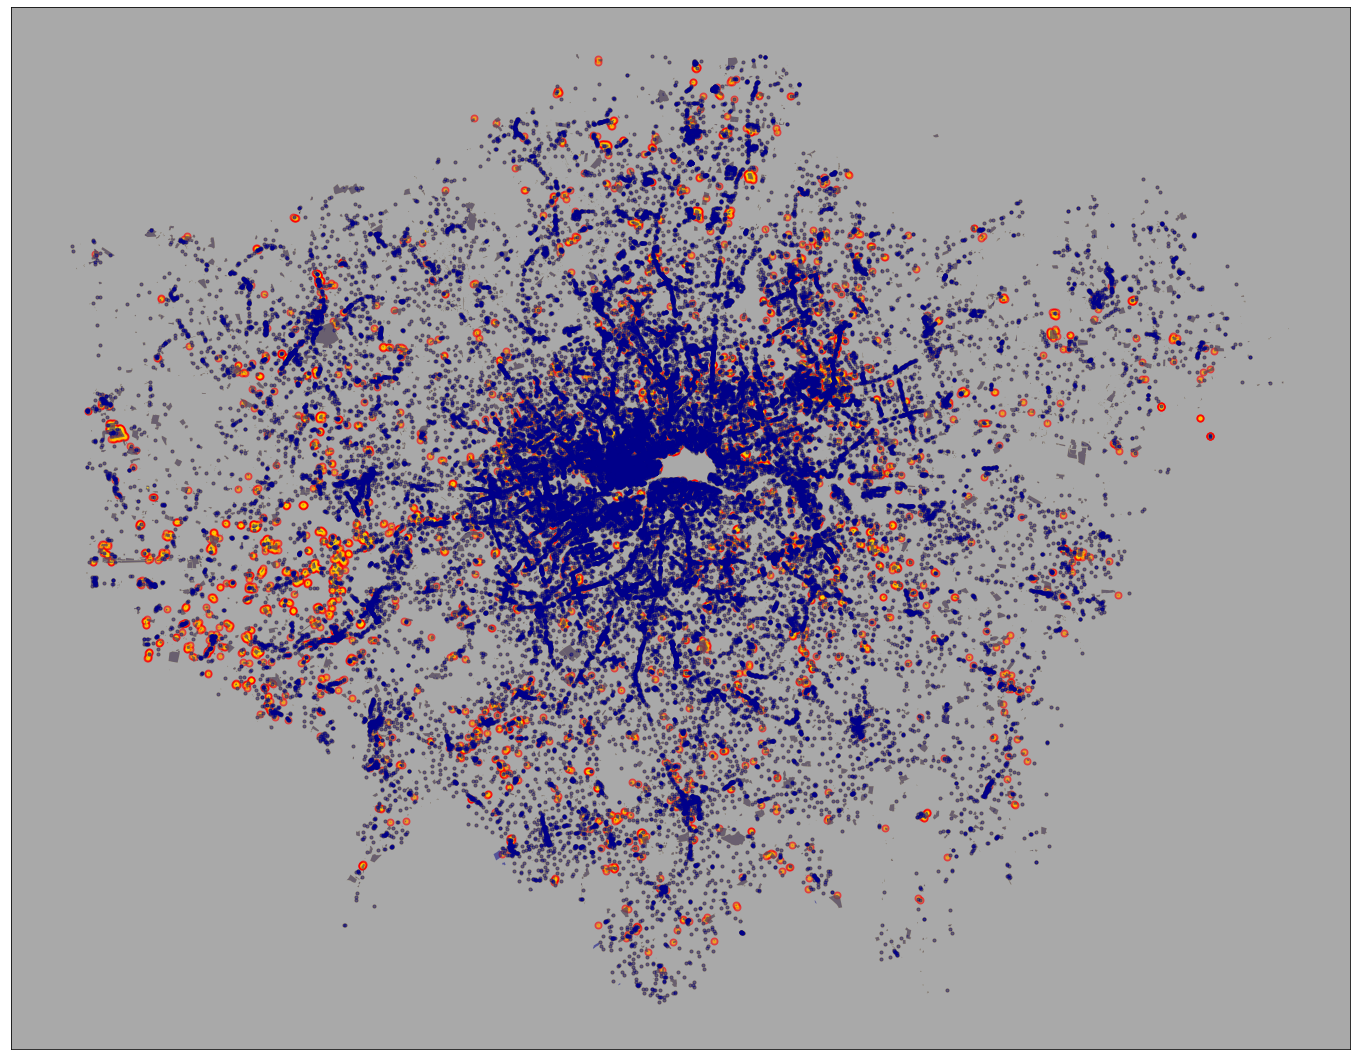

In [5]:
pois_amenities.to_crs(epsg=27700, inplace=True)
geometries_amenities.to_crs(epsg=27700, inplace=True)

fig,ax = plt.subplots(figsize=(24,24))
ax.set_facecolor('darkgrey')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

pois_amenities[pois_amenities_not_amenities].plot(ax=ax, alpha=0.5, color='red', markersize=50)
pois_amenities.plot(ax=ax, alpha=0.5, color='gold', markersize=10)
geometries_amenities.plot(ax=ax, alpha=0.5, color='darkblue', markersize=10)

### Comparison with https://overpass-turbo.eu/

***Initial query*** `amenity=* in London` ***in the wizard**

In [6]:
print((pois_amenities['geometry'].geom_type == 'Point').sum(), "- number of points created by pois_from_place():")
print((geometries_amenities['geometry'].geom_type == 'Point').sum(), "- number of points created by gdf_from_place():")
print("56375 - number of points running the query `amenity=* in London` on https://overpass-turbo.eu/\n")

print((pois_amenities['geometry'].geom_type == 'LineString').sum(), "- number of lines created by pois_from_place():")
print((geometries_amenities['geometry'].geom_type == 'LineString').sum(), "- number of lines created by gdf_from_place():")
print("152 - number of lines running the query `amenity=* in London` on https://overpass-turbo.eu/\n")

print((pois_amenities['geometry'].geom_type == 'Polygon').sum(), "- number of polygons created by pois_from_place():")
print((geometries_amenities['geometry'].geom_type == 'Polygon').sum(), "- number of polygons created by gdf_from_place():")
print((geometries_amenities['geometry'].geom_type == 'MultiPolygon').sum(), "- number of multipolygons created by gdf_from_place():")
print((geometries_amenities['geometry'].geom_type == 'Polygon').sum() +
      (geometries_amenities['geometry'].geom_type == 'MultiPolygon').sum(), "- total number of multi/polygons create by gdf_from_place()")
print("26400 - number of polygons running the query `amenity=* in London` on https://overpass-turbo.eu/ (no separate number for multipolygons)")

61073 - number of points created by pois_from_place():
56373 - number of points created by gdf_from_place():
56375 - number of points running the query `amenity=* in London` on https://overpass-turbo.eu/

0 - number of lines created by pois_from_place():
105 - number of lines created by gdf_from_place():
152 - number of lines running the query `amenity=* in London` on https://overpass-turbo.eu/

26273 - number of polygons created by pois_from_place():
26323 - number of polygons created by gdf_from_place():
76 - number of multipolygons created by gdf_from_place():
26399 - total number of multi/polygons create by gdf_from_place()
26400 - number of polygons running the query `amenity=* in London` on https://overpass-turbo.eu/ (no separate number for multipolygons)


### Notes

- `pois` returns more points partly for the reasons above - it doesn't filter the final gdf
- `pois` doesn't return lines because it tries to convert every way to a polygon
- The console log showed that two multipolygon relations could not be converted to polygons this was due to missing `role:outer` tags

### The difference between relations and multipolygon relations

- the initial wizard query on overpass-turbo.eu `amenity=* in London` includes generic relations in the results
- `geometries` strictly processes *multipolygon* relations

This means that the overpass-turbo.eu results include relations (such as this  one for UCL https://www.openstreetmap.org/relation/34627#map=15/51.5255/-0.1142) which are loose collections of points, lines and polygons but not geometries in their own right and their members are not necessarily tagged with `amenity` in their own right.

***The comparative query to run in the wizard on overpass-turbo.eu would be:***

`amenity=* and (type:node or type:way or (type:relation and type=multipolygon)) in London`

### Comparing results - ways only

Downloading the .geojson for all amenities in London from overpass-turbo.eu and trying to read it into GeoPandas crashed the kernel. Trying again having restricted the query to ways was succesful.

In [8]:
%%time
# Trying to read the overpass-turbo geojson into geopandas again - only ways this time
overpass_turbo_amenities_ways = gpd.read_file('/media/nick/WDBlue/osmnx/overpass_turbo_results/amenity_all_ways_in_london.geojson')
overpass_turbo_amenities_ways.to_crs(epsg=27700, inplace=True)

CPU times: user 29.3 s, sys: 999 ms, total: 30.3 s
Wall time: 33.6 s


### Compare generated columns

In [25]:
#sorted_cols = sorted(list(overpass_turbo_amenities_ways.columns))
overpass_turbo_amenities_ways = overpass_turbo_amenities_ways.reindex(sorted(overpass_turbo_amenities_ways.columns), axis=1)
overpass_turbo_amenities_ways.head(2)

,@id,FIXME,HE_ref,URN,abandoned,abutters,access,access:disabled,access:note,access:residents,access:source,accommodation,addr2:postcode,addr:city,addr:country,addr:district,addr:flat,addr:flats,addr:floor,addr:full,addr:hamlet,addr:housename,addr:housenumber,addr:housenumber:source,addr:interpolation,addr:parentstreet,addr:place,addr:postcode,addr:province,addr:source,addr:state,addr:street,addr:street:source,addr:street_1,addr:suburb,addr:unit,addr:village,affiliation,air_conditioning,alcohol,ale,alt_name,alt_name2,alt_name3,alt_name4,alt_name:es,alt_name_1,alt_website,ambulance,amenity,amenity:2,amenity:disused,amenity_1,amenity_2,anglican,animal_boarding,animal_shelter,architect,architect:wikidata,architect:wikipedia,area,artist_name,atm,atm:fee,attraction,audio_file,automated,automatic_door,award:michelin,backrest,bank,bar,barrier,beauty,beds,beer,beer_garden,bench,bicycle,bicycle_parking,billiards:pool,billiards:snooker,bin,boundary_type,branch,brand,brand:bn,brand:en,brand:website,brand:wikidata,brand:wikipedia,brand:zh,breakfast,brewery,broken_website,building,building:alt_name,building:architecture,building:cladding,building:colour,building:flats,building:floor,building:height,building:level,building:levels,building:levels:underground,building:levels_1,building:material,building:min_level,building:name,building:part,building:parts,building:roof,bus,cafe,cameras,camra,capacity,capacity:Commercial,capacity:CopperBoxUsers,capacity:EventsOnly,capacity:EventsOnlyDisabled,capacity:VeloParkUsers,capacity:bicycle,capacity:car_rental,capacity:car_share,capacity:carclub,capacity:coach,capacity:disabled,capacity:electric_charge,capacity:long,capacity:motorcycle,capacity:parent,capacity:standard,capacity:women,car_wash,cash,cat,cats,changing_table,changing_table:location,charge,check_date,checkfirst:suggested:name,childcare,church,clinic,closed,clothes,club,coach,cocktails,collection_times,college,colour,comedy,comment,community,community:en,community:gender,community_centre,community_centre:for,consecrated,construction,construction_date,consulate,contact:email,contact:facebook,contact:fax,contact:instagram,contact:linkedin,contact:phone,contact:twitter,contact:website,country,courthouse,covered,craft,craft_ale,craft_beer,craft_keg,created_by,crop,cuisine,cuisine_1,cuisine_2,culture,currency:XLT,date_start,deli,delivery,delivery:partner,demolished:building,denomination,denomination_1,department,depot,depth,description,description:floor,designation,destination,diaper,diet,diet:fruitarian,diet:gluten_free,diet:halal,diet:lactose_free,diet:meat,diet:raw,diet:vegan,diet:vegetarian,diocese,diplomatic,direction,disabled,disabled:description,disabled_spaces,discount:camra_member,dispensing,display,disused,disused:amenity,disused:area,disused:bicycle,disused:cuisine,disused:highway,disused:name,disused:railway,disused:segregated,disused:shop,disused:website,doctor,doctors,dog,dogging,dogs,dontimport:fhrs:addrline4,dontimport:fhrs:businesstype,door,drink,drink:afri-cola,drink:beer,drink:coffee,drink:soft_drink,drink:tea,drink:wine,drinkable,drinking_water,drive_through,eat_in,ele,electricity,email,embassy,emergency,entrance,epims:property_id,facebook,faces,fast_food,fax,fee,fee:0-30min,fee:amount,fee:conditional,fee:customers,fee:note,female,fhrs:authority,fhrs:confidence_management,fhrs:hygiene,fhrs:id,fhrs:inspectiondate,fhrs:local_authority_id,fhrs:name,fhrs:rating,fhrs:structural,fireplace,fish,fixme,fixme:addr2,flickr,floor:material,food,foot,for,former_amenity,former_name,fountain,franchise,fryup,fuel:diesel,fuel:lpg,fuel:octane_95,fuel:octane_98,full_name,furniture,gambling,garden,garden:type,gay,gender,generator:method,generator:output:electricity,generator:source,geometry,gluten_free,grades,green_roof,halal,happy_hours,happycow:id,he:inscription_date,he:name,he:ref,health_facility:type,healthcare,healthcare:speciality,height,heritage,heritage:operator,heritage:website,hgv,highlight,highway,historic,historic:amenity,historic:buildi

In [26]:
geometries_amenities = geometries_amenities.reindex(sorted(geometries_amenities.columns), axis=1)
geometries_amenities.head(2)

,FIXME,HE_ref,URN,abandoned,abutters,access,access:disabled,access:note,access:residents,access:source,access_disabled,accommodation,accomodation,addr2:postcode,addr:building,addr:city,addr:country,addr:county,addr:district,addr:door,addr:flat,addr:flats,addr:floor,addr:full,addr:hamlet,addr:housename,addr:housenumber,addr:housenumber:source,addr:in,addr:interpolation,addr:locality,addr:neighbourhood,addr:number,addr:parentstreet,addr:place,addr:postcode,addr:province,addr:source,addr:state,addr:street,addr:street:source,addr:street_1,addr:suburb,addr:town,addr:unit,addr:unitnumber,addr:village,address,affiliation,air_conditioning,alcohol,ale,alt_name,alt_name2,alt_name3,alt_name4,alt_name:es,alt_name_1,alt_postcode,alt_website,ambulance,amenity,amenity:2,amenity:disused,amenity_1,amenity_2,amperage,anglican,animal_boarding,animal_shelter,answer,architect,architect:wikidata,architect:wikipedia,area,art,artist:wikidata,artist:wikipedia,artist_name,artwork_subject,artwork_type,atm,atm:count,atm:fee,attraction,audio_file,authentication:membership_card,authentication:nfc,authentication:none,authentication:phone_call,authentication:short_message,authority,auto_compacting,automated,automatic,automatic_door,award:michelin,backrest,bank,bar,barrier,beauty,beds,beer,beer_garden,bench,bicycle,bicycle_parking,billiards:pool,billiards:snooker,bin,board_type,boltcutters,booth,bottle,bouncers,boundary_type,box_type,branch,brand,brand:bn,brand:en,brand:website,brand:wikidata,brand:wikipedia,brand:zh,breakfast,brewery,broken_website,building,building:alt_name,building:architecture,building:cladding,building:colour,building:flats,building:floor,building:height,building:level,building:levels,building:levels:underground,building:levels_1,building:material,building:min_level,building:name,building:part,building:parts,building:roof,burrito,bus,cafe,cameras,camra,capacity,capacity:Commercial,capacity:CopperBoxUsers,capacity:EventsOnly,capacity:EventsOnlyDisabled,capacity:VeloParkUsers,capacity:bicycle,capacity:car_rental,capacity:car_share,capacity:carclub,capacity:coach,capacity:disabled,capacity:electric_charge,capacity:long,capacity:motorcycle,capacity:parent,capacity:standard,capacity:women,car,car_wash,cargo,cash,cash_in,cat,cats,centralkey,changing_table,changing_table:count,changing_table:location,charge,charging_station,charging_station:capacity,charging_station:output,check_date,checkfirst:suggested:name,child,childcare,church,cinema:3D,clinic,clock,closed,clothes,club,coach,cocktails,coffee,collection_plate,collection_times,collection_times:signed,collection_times_checked,college,colour,comedy,comment,community,community:en,community:gender,community_centre,community_centre:for,consecrated,construction,construction_date,consulate,contact,contact:email,contact:facebook,contact:fax,contact:google_plus,contact:instagram,contact:linkedin,contact:phone,contact:pinterest,contact:twitter,contact:vimeo,contact:website,contact:youtube,cost,cost:coffee,count,country,courthouse,covered,cqc:id,cqc:location_id,cqc:provider_id,craft,craft_ale,craft_beer,craft_keg,created_by,crop,cuisine,cuisine_1,cuisine_2,culture,currency:EUR,currency:GBP,currency:GPB,currency:XBT,currency:XLT,currency:others,cyclestreets_id,date,date_start,deaf:description:en,deli,delivery,delivery:partner,demolished:building,denomination,denomination_1,department,depot,depth,description,description:floor,designation,destination,diaper,diet,diet:dairy_free,diet:fruitarian,diet:gluten_free,diet:halal,diet:lactose_free,diet:meat,diet:organic,diet:pescetarian,diet:raw,diet:vegan,diet:vegetarian,diocese,diplomatic,diplomatic:services:non-immigrant_visas,direction,disabled,disabled:description,disabled_spaces,discount:camra_member,dispensing,display,disused,disused:addr:postcode,disused:amenity,disused:area,disused:bicycle,disused:cuisine,disused:drinking_water,disused:highway,disused:name,disused:railway,disused:segregated,disused:shop,disused:website,doctor,doctors,dog,dogging,dogs,dont

### Look for results from overpass-turbo.eu that are not in the results from `geometries`

In [28]:
overpass_turbo_amenities_ways[~overpass_turbo_amenities_ways['id'].isin(geometries_amenities['unique_id'])]

,@id,FIXME,HE_ref,URN,abandoned,abutters,access,access:disabled,access:note,access:residents,access:source,accommodation,addr2:postcode,addr:city,addr:country,addr:district,addr:flat,addr:flats,addr:floor,addr:full,addr:hamlet,addr:housename,addr:housenumber,addr:housenumber:source,addr:interpolation,addr:parentstreet,addr:place,addr:postcode,addr:province,addr:source,addr:state,addr:street,addr:street:source,addr:street_1,addr:suburb,addr:unit,addr:village,affiliation,air_conditioning,alcohol,ale,alt_name,alt_name2,alt_name3,alt_name4,alt_name:es,alt_name_1,alt_website,ambulance,amenity,amenity:2,amenity:disused,amenity_1,amenity_2,anglican,animal_boarding,animal_shelter,architect,architect:wikidata,architect:wikipedia,area,artist_name,atm,atm:fee,attraction,audio_file,automated,automatic_door,award:michelin,backrest,bank,bar,barrier,beauty,beds,beer,beer_garden,bench,bicycle,bicycle_parking,billiards:pool,billiards:snooker,bin,boundary_type,branch,brand,brand:bn,brand:en,brand:website,brand:wikidata,brand:wikipedia,brand:zh,breakfast,brewery,broken_website,building,building:alt_name,building:architecture,building:cladding,building:colour,building:flats,building:floor,building:height,building:level,building:levels,building:levels:underground,building:levels_1,building:material,building:min_level,building:name,building:part,building:parts,building:roof,bus,cafe,cameras,camra,capacity,capacity:Commercial,capacity:CopperBoxUsers,capacity:EventsOnly,capacity:EventsOnlyDisabled,capacity:VeloParkUsers,capacity:bicycle,capacity:car_rental,capacity:car_share,capacity:carclub,capacity:coach,capacity:disabled,capacity:electric_charge,capacity:long,capacity:motorcycle,capacity:parent,capacity:standard,capacity:women,car_wash,cash,cat,cats,changing_table,changing_table:location,charge,check_date,checkfirst:suggested:name,childcare,church,clinic,closed,clothes,club,coach,cocktails,collection_times,college,colour,comedy,comment,community,community:en,community:gender,community_centre,community_centre:for,consecrated,construction,construction_date,consulate,contact:email,contact:facebook,contact:fax,contact:instagram,contact:linkedin,contact:phone,contact:twitter,contact:website,country,courthouse,covered,craft,craft_ale,craft_beer,craft_keg,created_by,crop,cuisine,cuisine_1,cuisine_2,culture,currency:XLT,date_start,deli,delivery,delivery:partner,demolished:building,denomination,denomination_1,department,depot,depth,description,description:floor,designation,destination,diaper,diet,diet:fruitarian,diet:gluten_free,diet:halal,diet:lactose_free,diet:meat,diet:raw,diet:vegan,diet:vegetarian,diocese,diplomatic,direction,disabled,disabled:description,disabled_spaces,discount:camra_member,dispensing,display,disused,disused:amenity,disused:area,disused:bicycle,disused:cuisine,disused:highway,disused:name,disused:railway,disused:segregated,disused:shop,disused:website,doctor,doctors,dog,dogging,dogs,dontimport:fhrs:addrline4,dontimport:fhrs:businesstype,door,drink,drink:afri-cola,drink:beer,drink:coffee,drink:soft_drink,drink:tea,drink:wine,drinkable,drinking_water,drive_through,eat_in,ele,electricity,email,embassy,emergency,entrance,epims:property_id,facebook,faces,fast_food,fax,fee,fee:0-30min,fee:amount,fee:conditional,fee:customers,fee:note,female,fhrs:authority,fhrs:confidence_management,fhrs:hygiene,fhrs:id,fhrs:inspectiondate,fhrs:local_authority_id,fhrs:name,fhrs:rating,fhrs:structural,fireplace,fish,fixme,fixme:addr2,flickr,floor:material,food,foot,for,former_amenity,former_name,fountain,franchise,fryup,fuel:diesel,fuel:lpg,fuel:octane_95,fuel:octane_98,full_name,furniture,gambling,garden,garden:type,gay,gender,generator:method,generator:output:electricity,generator:source,geometry,gluten_free,grades,green_roof,halal,happy_hours,happycow:id,he:inscription_date,he:name,he:ref,health_facility:type,healthcare,healthcare:speciality,height,heritage,heritage:operator,heritage:website,hgv,highlight,highway,historic,historic:amenity,historic:buildi

#### Note:

Looking at the edited date on openstreetmap.org it seems both of these were created between the time that `geometries` got its data and the .geojson was downloaded from overpass-turbo.eu

### Compare number of LineStrings in both results

In [30]:
len(overpass_turbo_amenities_ways[overpass_turbo_amenities_ways['geometry'].geom_type == 'LineString'])

105

In [31]:
len(geometries_amenities[geometries_amenities['geometry'].geom_type == 'LineString'])

105

#### Note:

Filtering to LineStrings the number of results is identical

### Compare number of ways in both results

In [50]:
print(len(overpass_turbo_amenities_ways), "overpass-turbo ways")

26291 overpass-turbo ways


In [51]:
print(len(geometries_amenities[geometries_amenities['unique_id'].str[:3] == 'way']), "geometries polygons")

26289 geometries polygons


#### Note:

Filtering to polygons is not comparable as the `geometries` result includes polygons created from multipolygon relations
Filtering to geometries that were originally ways (not relations), the results are identical apart from the 2 already noted above